## Importing info and making a DF

In [2]:
import pandas as pd
import numpy as np

orders = pd.read_csv('Orders.csv')

## Getting to know the data

In [3]:
print(orders.columns)
print(orders.describe())

Index(['Row.ID', 'Order.ID', 'Order.Date', 'Ship.Date', 'Ship.Mode',
       'Customer.ID', 'Customer.Name', 'Segment', 'Postal.Code', 'City',
       'State', 'Country', 'Region', 'Market', 'Product.ID', 'Category',
       'Sub.Category', 'Product.Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping.Cost', 'Order.Priority'],
      dtype='object')
            Row.ID   Postal.Code      Quantity      Discount  Shipping.Cost
count  51290.00000   9994.000000  51290.000000  51290.000000   51290.000000
mean   25645.50000  55190.379428      3.476545      0.142908      26.478567
std    14806.29199  32063.693350      2.278766      0.212280      57.251373
min        1.00000   1040.000000      1.000000      0.000000       1.002000
25%    12823.25000           NaN      2.000000      0.000000       2.610000
50%    25645.50000           NaN      3.000000      0.000000       7.790000
75%    38467.75000           NaN      5.000000      0.200000      24.450000
max    51290.00000  99301.0000

C:\Users\Stephen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [ ]:
orders.head()
orders.isnull()

In [ ]:
orders.dtypes
orders

## Cleaning the Data

In [6]:
orders.Profit = orders.Profit.str.replace('$','').str.replace(',','').astype(float)

In [7]:
#making date-time and creating new columns for month and year

orders['Order.Date'] = pd.to_datetime(orders['Order.Date'])
orders["order_month"] = orders["Order.Date"].apply (lambda x : x.month)
orders.order_month = orders.order_month.astype(int)

orders["order_year"] = orders["Order.Date"].apply(lambda x : x.year)
orders.order_year = orders.order_year

## Figuring out seasonal trends

In [24]:
season_orders = orders.groupby('order_month')['Quantity'].agg(['min', 'max', 'mean', 'sum', 'median'])

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

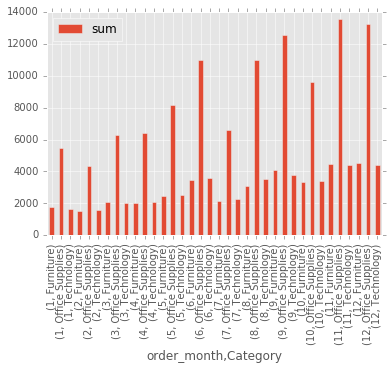

In [26]:
season_cat = orders.groupby(['order_month','Category'])['Quantity'].agg(['sum'])
plt.figure(figsize=(16,6))
season_cat.plot.bar()

## Comb orders and returns

In [9]:
returns = pd.read_csv('Returns.csv')

In [10]:
returns.head()

,Returned,Order ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


## Figuring out what profit we lost

In [ ]:
print(orders.shape)
print(returns.shape)

In [11]:
comb_df = orders.merge(returns, left_on='Order.ID', right_on='Order ID')

In [ ]:
comb_df['Order ID'].nunique()

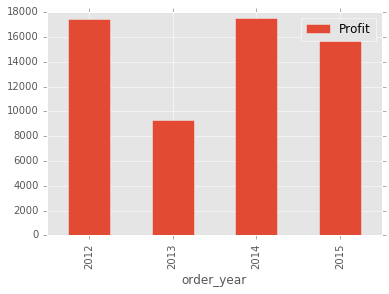

In [23]:
year_loss = comb_df.groupby(['order_year'])[['Profit']].sum()
year_loss.plot.bar()